In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import os
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [20]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "liver2.csv")
df = pd.read_csv(data_path)

In [24]:
df = df.dropna()
limit = 480
df=df[df['Actual Room Duration']<limit]

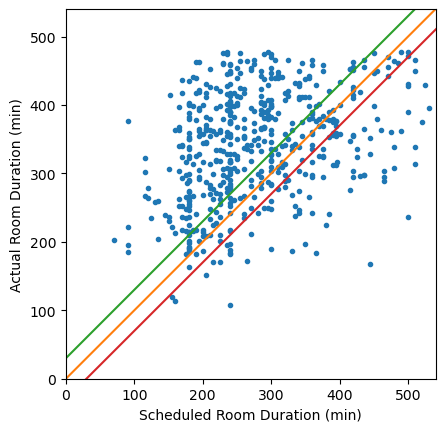

In [26]:
plt.plot(df['Scheduled Room Duration'],df['Actual Room Duration'],'.')
plt.gca().set_aspect('equal')
plt.plot((0, 1000), (0, 1000))
plt.plot((0, 1000), (30, 1030))
plt.plot((0, 1000), (-30, 970))
plt.xlim(0, limit+60)
plt.ylim(0, limit+60)
plt.xlabel('Scheduled Room Duration (min)')
plt.ylabel('Actual Room Duration (min)')
plt.show()

Text(0.5, 0, 'Age (years)')

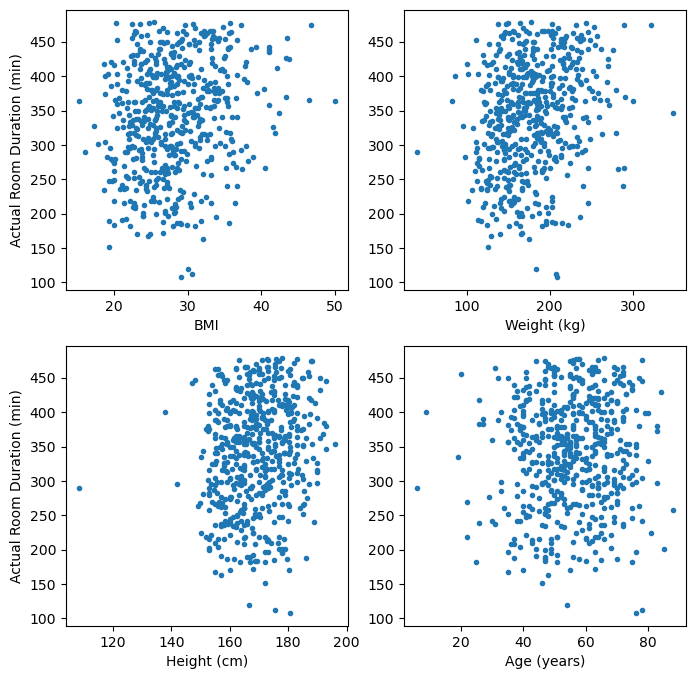

In [27]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs[0,0].plot(df['BMI'],df['Actual Room Duration'],'.')
axs[0,0].set_xlabel('BMI')
axs[0,0].set_ylabel('Actual Room Duration (min)')
axs[0,1].plot(df['Weight (kg)'],df['Actual Room Duration'],'.')
axs[0,1].set_xlabel('Weight (kg)')
axs[1,0].plot(df['Height (cm)'],df['Actual Room Duration'],'.')
axs[1,0].set_xlabel('Height (cm)')
axs[1,0].set_ylabel('Actual Room Duration (min)')
axs[1,1].plot(df['Age at Surgery'],df['Actual Room Duration'],'.')
axs[1,1].set_xlabel('Age (years)')

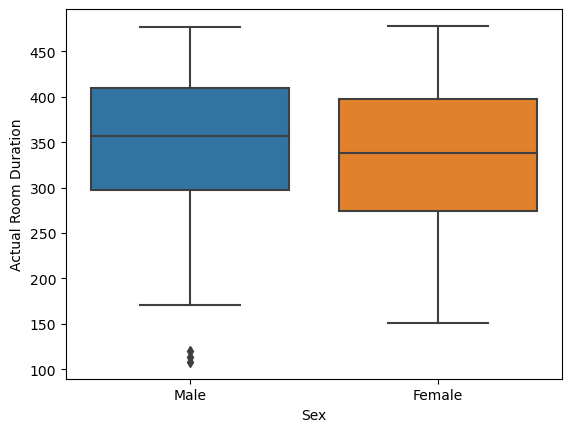

In [28]:
sb.boxplot( x = 'Sex',y = 'Actual Room Duration', data = df )

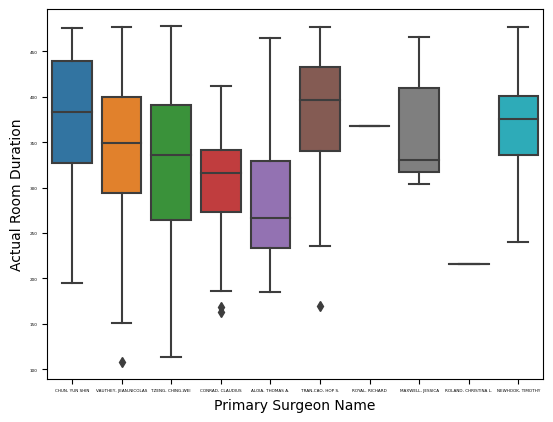

In [29]:
b = sb.boxplot( x = 'Primary Surgeon Name',y = 'Actual Room Duration', data = df )
b.tick_params(labelsize=3)

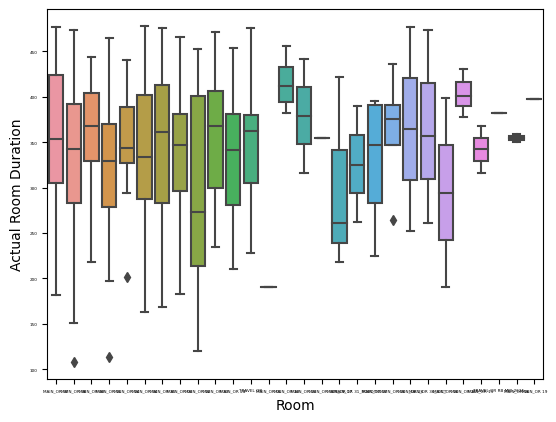

In [30]:
b = sb.boxplot(x = 'Room',y = 'Actual Room Duration', data = df )
b.tick_params(labelsize=3)

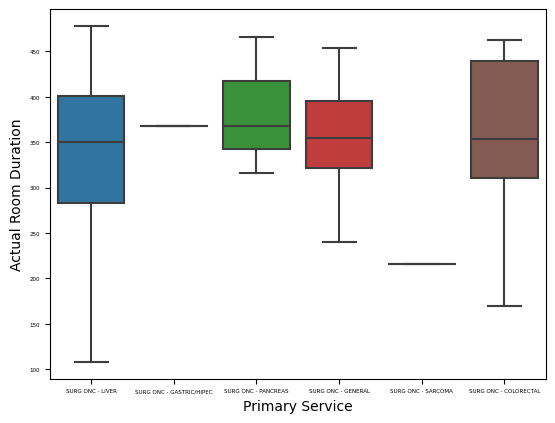

In [31]:
b = sb.boxplot(x = 'Primary Service',y = 'Actual Room Duration', data = df )
b.tick_params(labelsize=4)

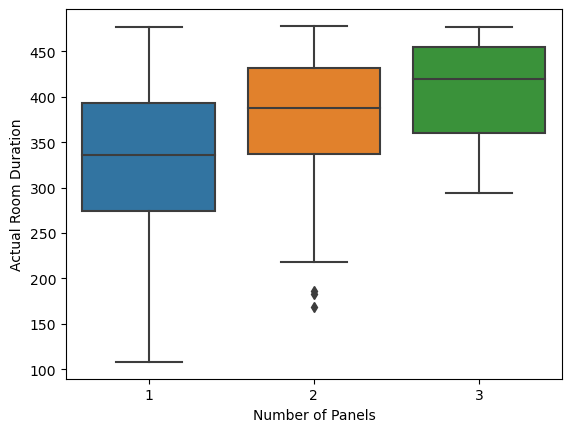

In [32]:
b = sb.boxplot(x = 'Number of Panels',y = 'Actual Room Duration', data = df )

In [33]:
features_to_encode = ['Primary Surgeon Name', 'Primary Service', 'Sex', 'Room']
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [34]:
X = df[['Primary Surgeon Name', 'Primary Service', 'Sex','Room','Number of Panels','Scheduled Room Duration', 'BMI', 'Age at Surgery', 'Height (cm)','Weight (kg)']]
y = df['Actual Room Duration']


In [35]:
# model = LinearRegression()
model = GradientBoostingRegressor()
pipe = make_pipeline(col_trans, model)
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Primary Surgeon Name',
                                                   'Primary Service', 'Sex',
                                                   'Room'])],
                                   verbose=...
  

In [36]:
y_pred = pipe.predict(X)

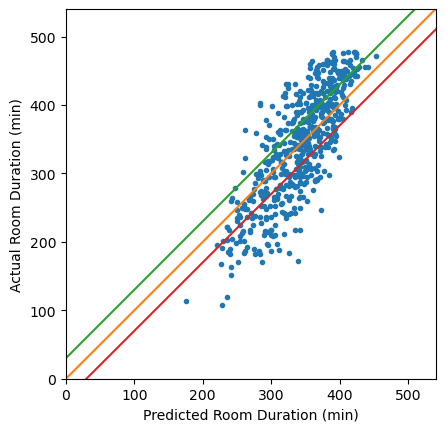

In [37]:
plt.plot(y_pred,y,'.')
plt.gca().set_aspect('equal')
plt.plot((0, 1000), (0, 1000))
plt.plot((0, 1000), (30, 1030))
plt.plot((0, 1000), (-30, 970))
plt.xlim(0, limit+60)
plt.ylim(0, limit+60)
plt.xlabel('Predicted Room Duration (min)')
plt.ylabel('Actual Room Duration (min)')
plt.show()